In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from yellowbrick.cluster import  KElbowVisualizer


## Preprocessing 1 ##

The program expects corrected input file. We have manually corrected the shifted rows and removed the ID column, as it was potentially misleading. Columns with identical descriptions contain the same or nearly the same data, although they may not share the same ID. Ensure that you use the corrected CSV file we provided.

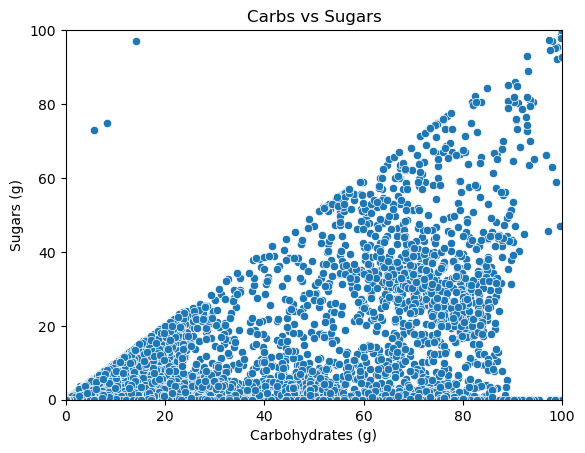

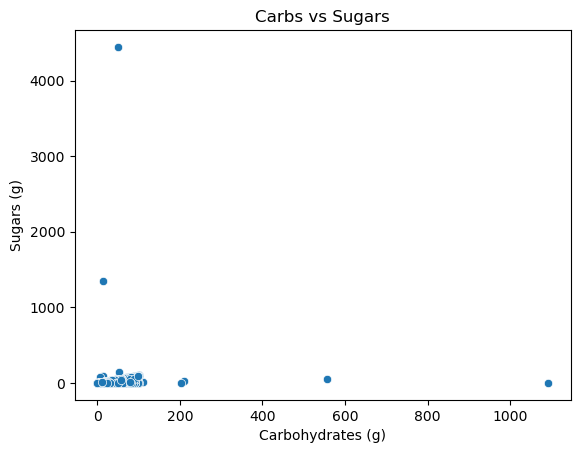

In [3]:
# format columns and add computed columns
def preprocess1(data):
    data["id"] = data.index
    data["Energy_kcal"] = data["Energy_kcal"].round() # should be int and most values actually are int
    data["Magnesium_mg"] = pd.to_numeric(data["Magnesium_mg"], errors="coerce")
    data["VitE_mg"] = pd.to_numeric(data["VitE_mg"], errors="coerce")
    # data.drop_duplicates(inplace=True)
    data.drop_duplicates(subset="Descrip", inplace=True) # Rows with the same description are almost same.
    data["contains_B12"] = data["VitB12_mcg"] != 0.0

def plot_sugar_carb(data, range_x=False, range_y=False):
    sns.scatterplot(x=data['Carb_g'], y=data['Sugar_g'])
    plt.title('Carbs vs Sugars')
    plt.xlabel('Carbohydrates (g)')
    plt.ylabel('Sugars (g)')
    if range_x:
        plt.xlim(0, range_x)
    if range_y:
        plt.ylim(0, range_y)
    plt.show()

def plot_graphs(data, range_x=False, range_y=False):
    data.describe()
    plot_sugar_carb(data, range_x, range_y)
    sns.pairplot(data, vars=["Energy_kcal", "Protein_g", "Saturated_fats_g", "Fiber_g", "Magnesium_mg", "Niacin_mg" , "Folate_mcg"], hue="contains_B12")
    sns.pairplot(data, vars=["Energy_kcal", "Protein_g", "Saturated_fats_g"], hue="contains_B12")
    sns.pairplot(data, vars=["Fiber_g", "Magnesium_mg", "Niacin_mg" , "Folate_mcg"], hue="contains_B12")

train_data = pd.read_csv("ingredients.csv", keep_default_na=True)
train_data["id"] = train_data.index
preprocess1(train_data)
train_features = train_data.drop(columns=["id", "Descrip"])
train_metadata = train_data["Descrip"]

# for future evaluation of outlayer detection
plot_sugar_carb(train_features, 100, 100)
plot_sugar_carb(train_features)

ss = StandardScaler()
pipe_prepro = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="median"),
    ss,
)
train_features = pd.DataFrame(pipe_prepro.fit_transform(train_features), columns=train_features.columns)
pipe_factor = make_pipeline(LocalOutlierFactor(n_neighbors = 30))
label = pipe_factor.fit_predict(train_features)
train_features = train_features[label == 1].reset_index(drop=True)
train_data = train_data[label == 1].reset_index(drop=True)
train_metadata = train_metadata[label == 1].reset_index(drop=True)


## Exploration analysis ##

At sugar-carb graph we can see, that at least some outlayers were succesfully removed. \
Distribution of some features differs based on if the the ingredient contains B12. So B12 can be qait important. Let's see just a few examples.

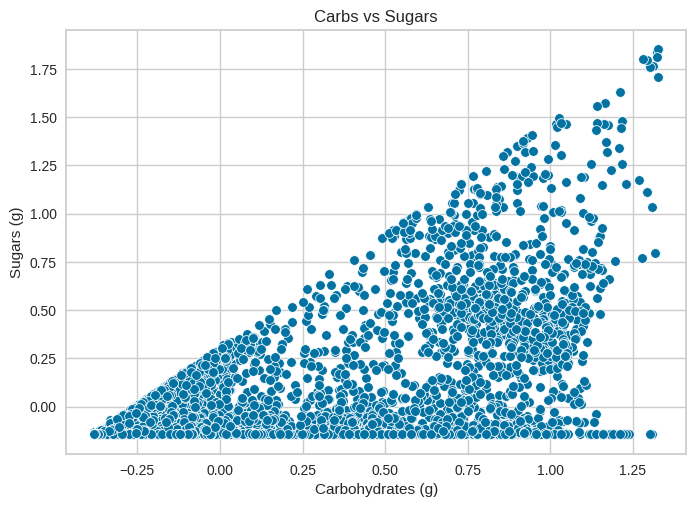

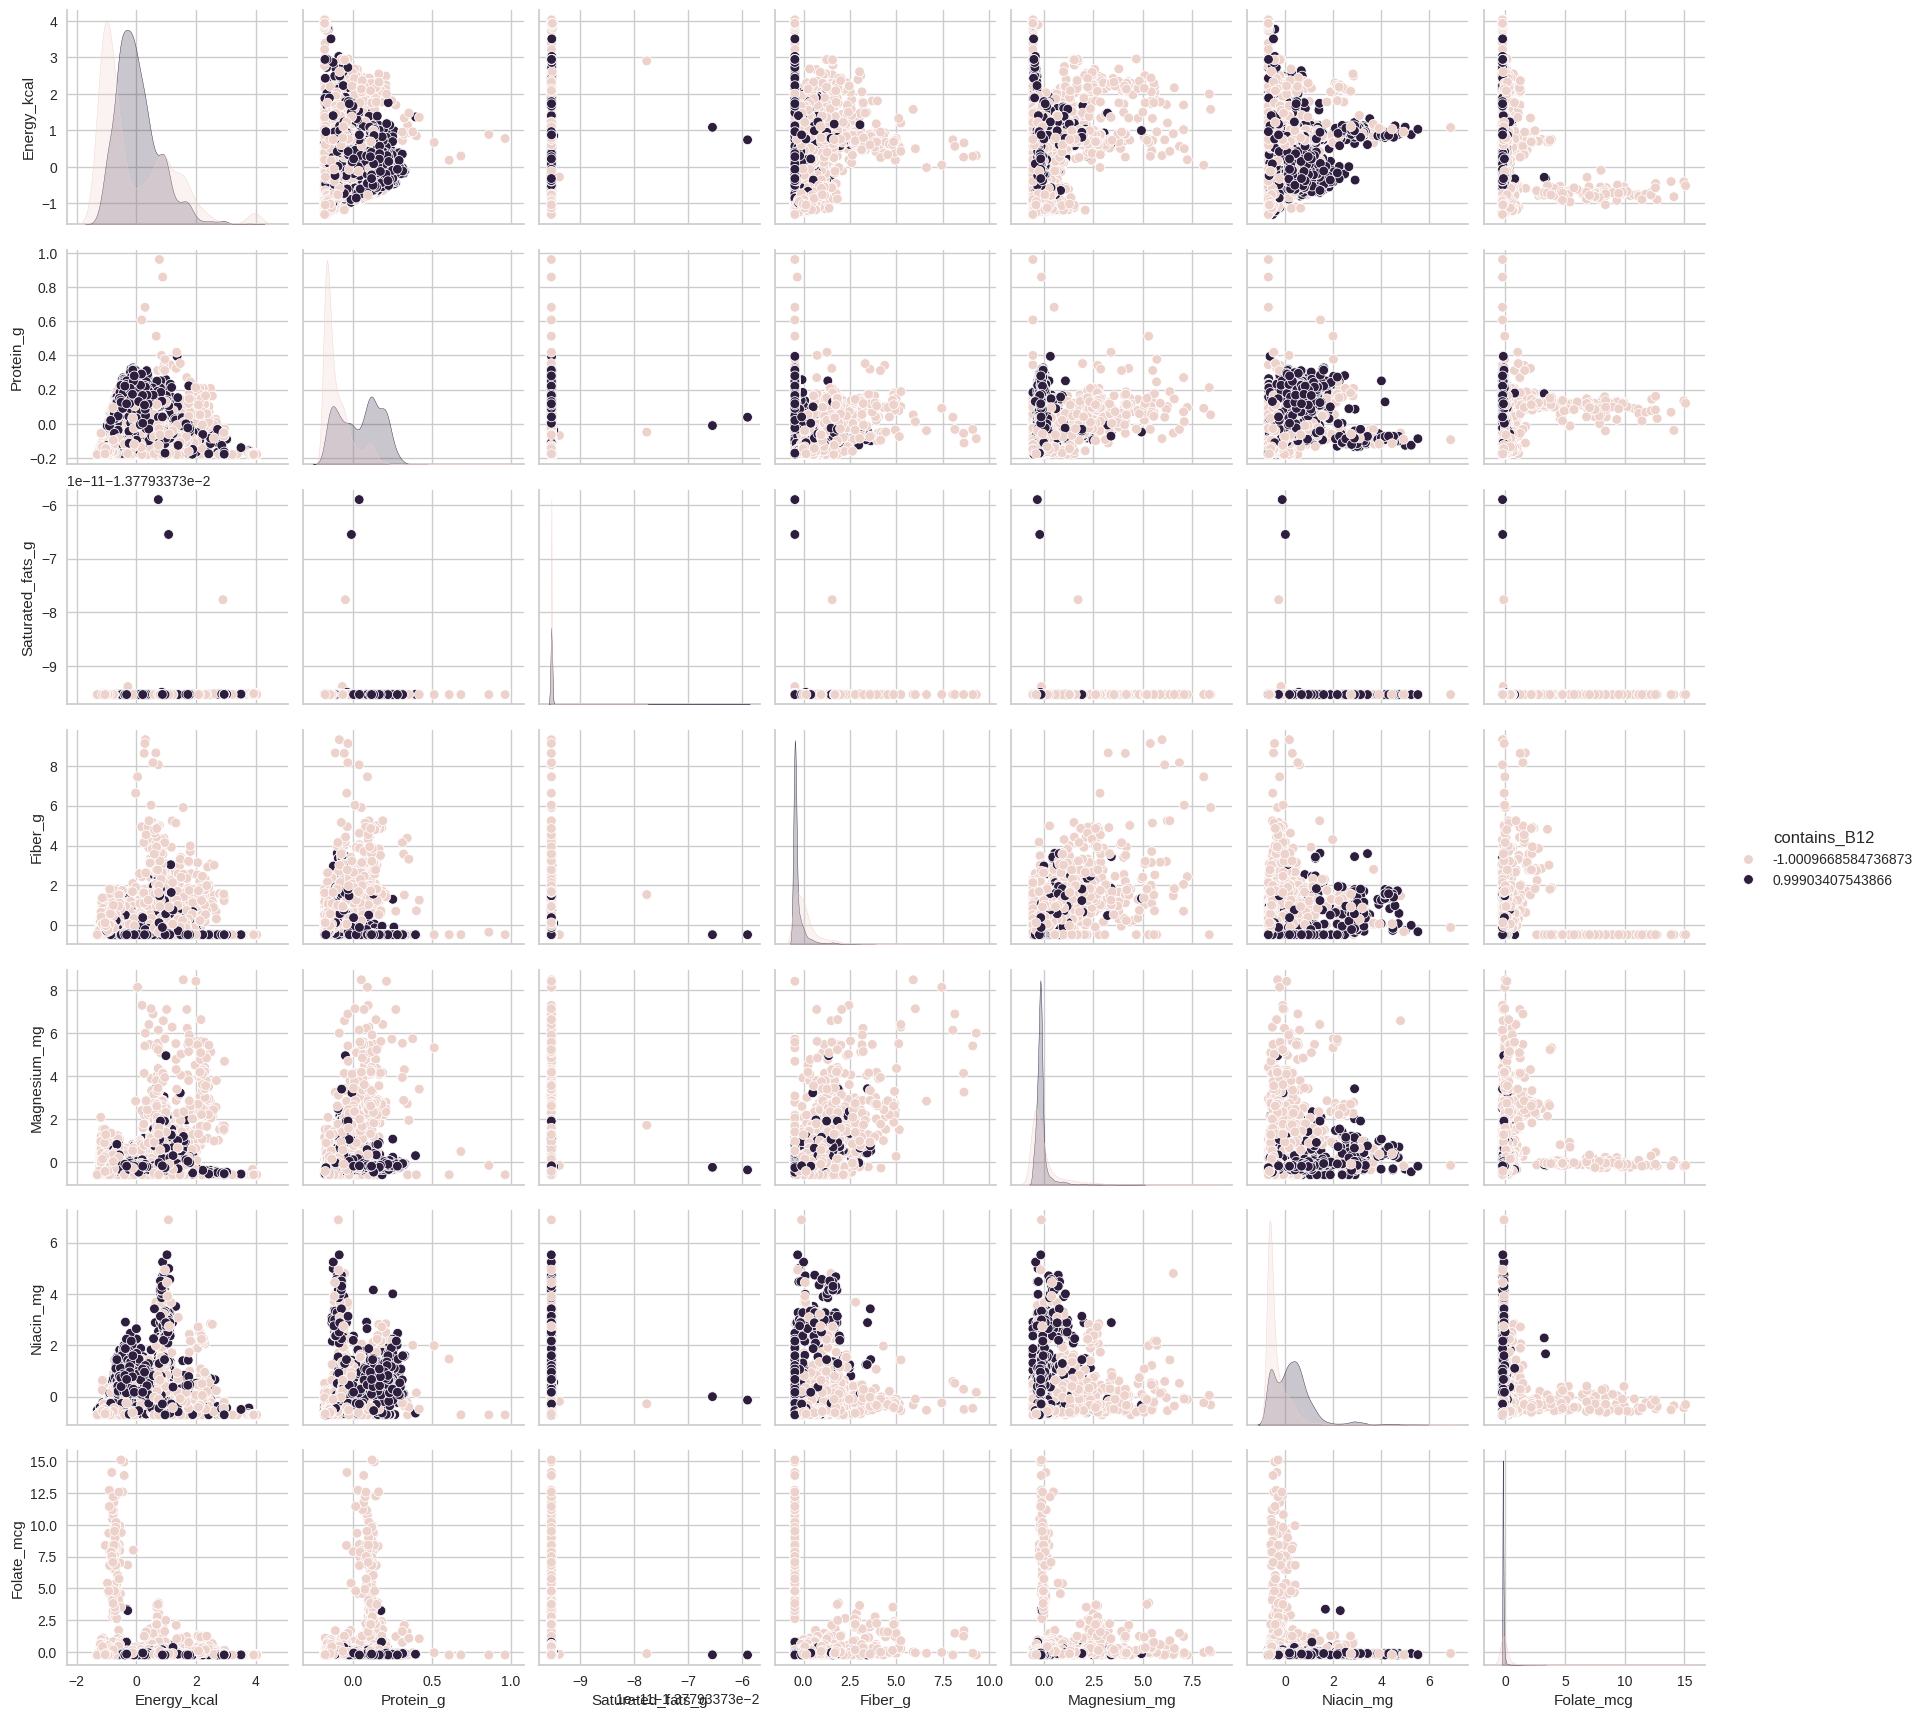

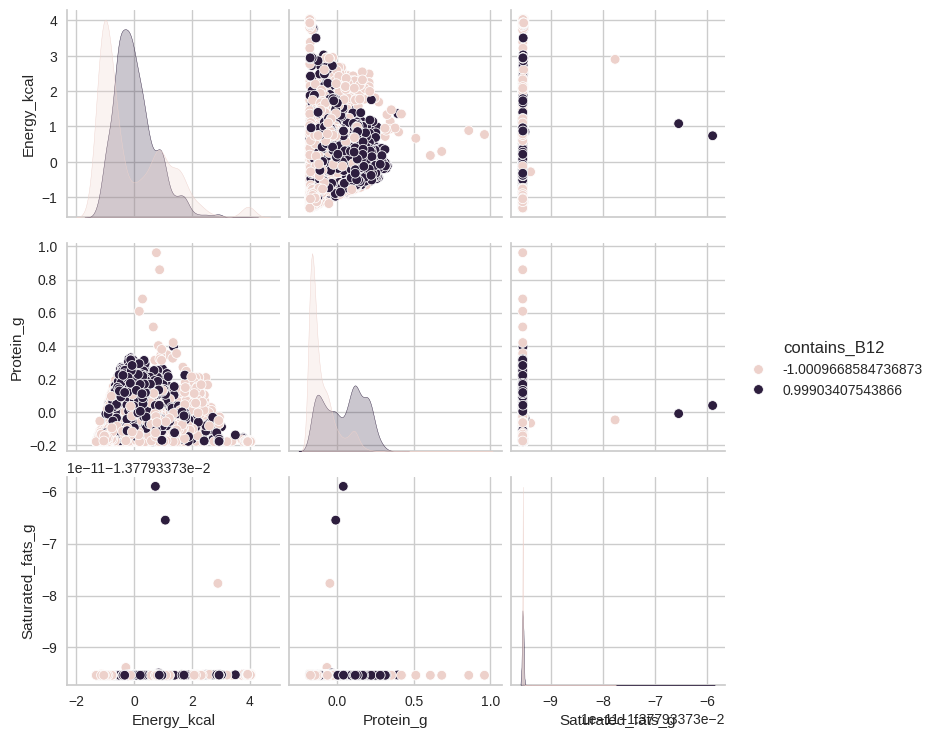

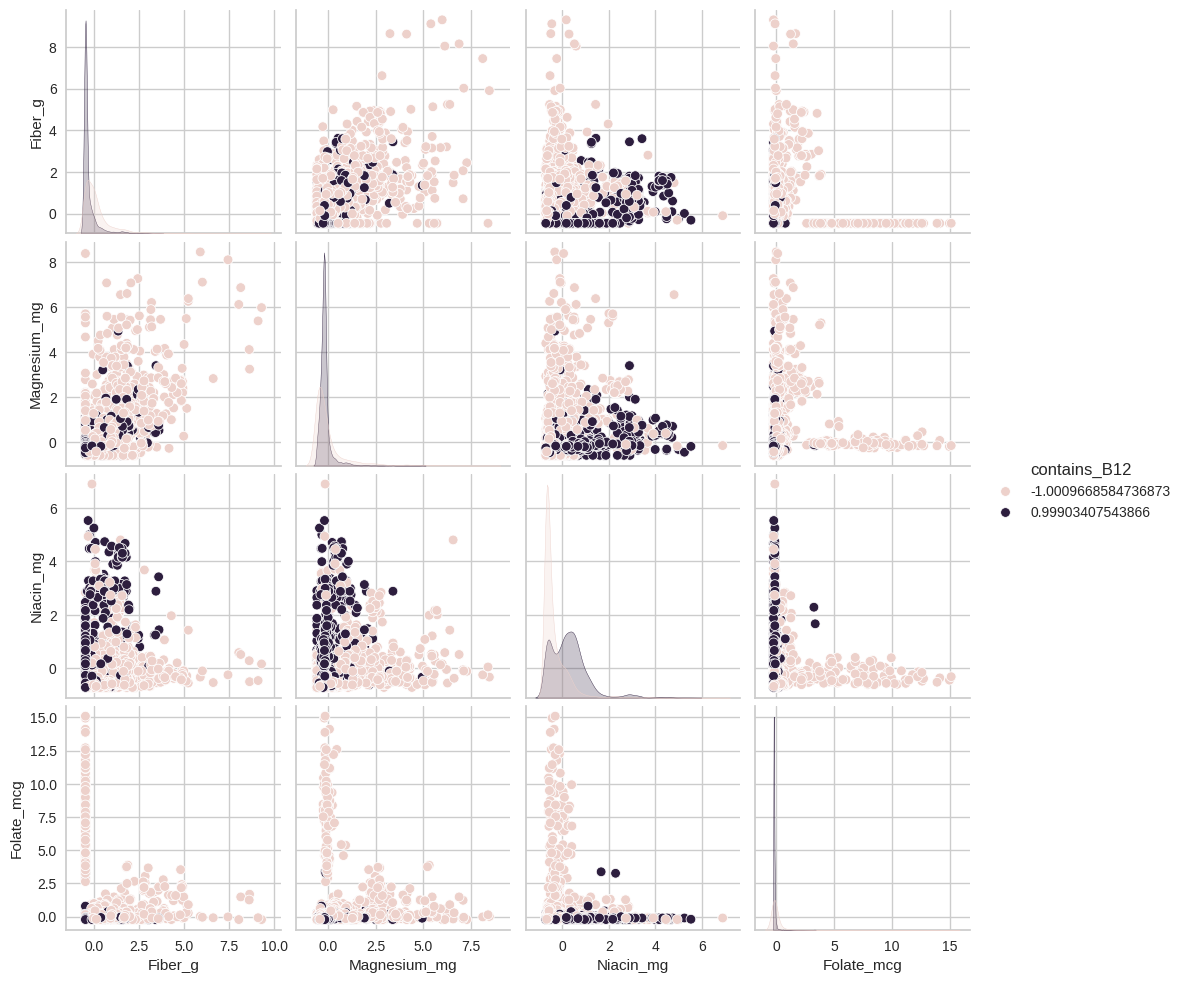

In [59]:
plot_graphs(train_features)

,Energy_kcal,Protein_g,Saturated_fats_g,Fat_g,Carb_g,Fiber_g,Sugar_g,Calcium_mg,Iron_mg,Magnesium_mg,...,Thiamin_mg,Riboflavin_mg,Niacin_mg,VitB6_mg,Folate_mcg,VitB12_mcg,VitA_mcg,VitE_mg,VitD2_mcg,contains_B12
Energy_kcal,1.000000,0.104163,0.044222,0.806400,0.521360,0.238342,0.329857,0.178562,0.236858,0.305932,...,0.336438,0.263334,0.231552,-0.073787,-0.059283,0.015072,0.054816,0.348144,0.067906,0.039722
Protein_g,0.104163,1.000000,0.006098,0.086083,-0.326514,-0.114556,-0.299008,0.029735,0.110044,0.188693,...,0.108911,0.230606,0.525721,0.101633,0.101935,0.443657,-0.078977,-0.018944,0.066718,0.542689
Saturated_fats_g,0.044222,0.006098,1.000000,0.064425,-0.013542,-0.002503,-0.005382,-0.002862,-0.005356,0.004356,...,-0.003529,-0.008918,-0.002250,-0.003530,-0.005665,-0.007427,-0.001717,0.003901,-0.001429,0.014346
Fat_g,0.806400,0.086083,0.064425,1.000000,-0.022123,-0.010356,0.019984,0.073217,-0.017260,0.138643,...,0.028342,0.008811,0.024634,-0.056927,-0.062882,0.001760,0.022028,0.412714,0.016212,0.082487
Carb_g,0.521360,-0.326514,-0.013542,-0.022123,1.000000,0.482592,0.620252,0.199379,0.381078,0.280392,...,0.471685,0.332548,0.143623,-0.082149,-0.046770,-0.151769,0.094991,0.050609,0.061744,-0.262343
Fiber_g,0.238342,-0.114556,-0.002503,-0.010356,0.482592,1.000000,0.121020,0.315862,0.371633,0.648720,...,0.319955,0.169484,0.061405,-0.055271,0.074610,-0.136453,0.033483,0.156621,-0.026776,-0.316619
Sugar_g,0.329857,-0.299008,-0.005382,0.019984,0.620252,0.121020,1.000000,0.120176,0.155331,0.001992,...,0.166839,0.186915,0.011072,-0.051055,-0.068588,-0.069400,0.108573,0.060065,0.140970,-0.111706
Calcium_mg,0.178562,0.029735,-0.002862,0.073217,0.199379,0.315862,0.120176,1.000000,0.375465,0.369574,...,0.222725,0.290820,0.072733,-0.021724,0.015584,0.003153,0.188144,0.107885,0.172248,0.068278
Iron_mg,0.236858,0.110044,-0.005356,-0.017260,0.381078,0.371633,0.155331,0.375465,1.000000,0.354442,...,0.611208,0.663860,0.544508,-0.023975,0.002736,0.267378,0.241448,0.066886,0.200624,0.057601
Magnesium_mg,0.305932,0.188693,0.004356,0.138643,0.280392,0.648720,0.001992,0.369574,0.354442,1.000000,...,0.334247,0.202270,0.202091,0.011083,0.137027,-0.026529,0.023157,0.259941,0.020231,-0.136379


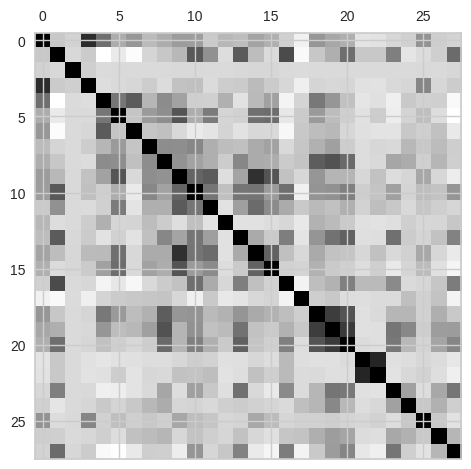

In [61]:
plt.matshow(train_features.corr())
train_features.corr()

Many features have corelation over 60 %. Eg. energi and fat over 80 %. \
So dimension reduction si something to try.

## Preprocessing 2

Removing highly corelated features.

In [4]:
# train_features.pop("Energy_kcal") # Fat
# train_features.pop("VitB6_mg") #
# train_features.pop("Sugar_g") #
# #train_features.pop("Carb_g")
# train_features.pop("Copper_mcg") #
# train_features.pop("Potassium_mg") #
# train_features.pop("Thiamin_mg") # 68 % zinek
# train_features.pop("Magnesium_mg") # 64 % Fiber_g
# train_features.pop("Phosphorus_mg") # 62 % protein
# train_features.info()


pca = PCA(n_components=15)

train_features = pca.fit_transform(train_features)

## Models

In this part of the project, we explored various clustering models applied to our dataset. For all models, we used three primary metrics to evaluate the resulting clusters: the **Silhouette Score**, the **Davies–Bouldin Index**, and the **Calinski–Harabasz Index**. However, none of these metrics serves as the primary criterion for evaluation, as we will discuss later.

- **Silhouette Score**: Assesses how similar a data point is to its own cluster compared to other clusters.  
  The score ranges from -1 to 1, with higher values indicating more well-defined clusters.

- **Davies–Bouldin Index**: Measures the average similarity between each cluster and its most similar cluster.  
  Lower values indicate better clustering performance.

- **Calinski–Harabasz Index**: Calculates the ratio of between-cluster dispersion to within-cluster dispersion.  
  Higher values signify better-defined clusters.


In [15]:
def plot_silhouette_diagram(X, labels, n_clusters, title="Silhouette Plot"):
    """
    Plots the silhouette diagram for clustering results.

    Parameters:
        X (array-like): Feature dataset.
        labels (array-like): Cluster labels for each sample.
        n_clusters (int): Number of clusters.
        title (str): Plot title.
    """
    silhouette_vals = silhouette_samples(X, labels)
    silhouette_avg = silhouette_score(X, labels)

    plt.figure(figsize=(8, 5))
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = silhouette_vals[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.title(title)
    plt.show()

#Method for saving final clusters. Will be used for result interpretation
def save_clusters(data, labels, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    unique_labels = set(labels)

    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)

    for label in unique_labels:
        cluster_df = data[labels == label]
        cluster_df.to_csv(f"{folder}/{prefix}_cluster_{label}.csv", index=False)


### Baseline

KMeans silhouette:  0.261
KMeans Calinski Harabasz:  1600.986
KMeans Davis bouldin:  1.711


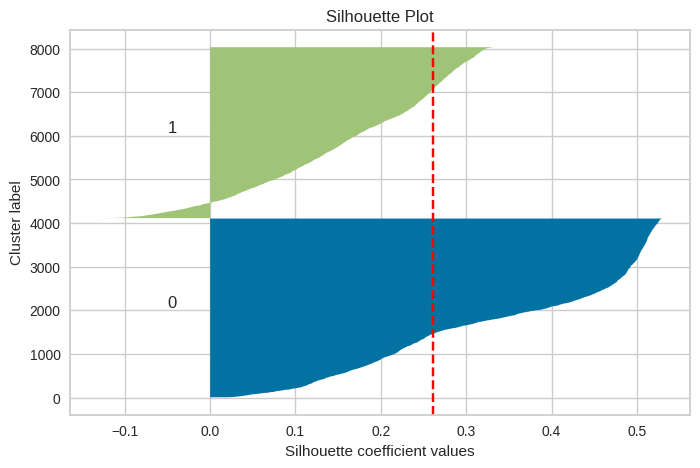

In [17]:
baseline = KMeans(n_clusters=2, random_state=42)
baseline_labels = baseline.fit_predict(train_features)

baseline_silhouette = silhouette_score(train_features, baseline_labels)
baseline_davis = davies_bouldin_score(train_features, baseline_labels)
baseline_clainski = calinski_harabasz_score(train_features, baseline_labels)
print("KMeans silhouette: ", round(baseline_silhouette, 3))
print("KMeans Calinski Harabasz: ", round(baseline_clainski, 3))
print("KMeans Davis bouldin: ", round(baseline_davis, 3))


plot_silhouette_diagram(train_features, baseline_labels, 2)

save_clusters(train_metadata, baseline_labels,'baseline_description', "kmeans")

### Models and Their Training




#### Kmeans
##### K-means clustering performs well on numerical, continuous data that is evenly scaled and forms roughly spherical, equally sized clusters. On the Silhouette Plot for our data set  we obserwed unequal distribution of the clusters. This couuld leave to the incorrect clustering for Kmeans algorithm.

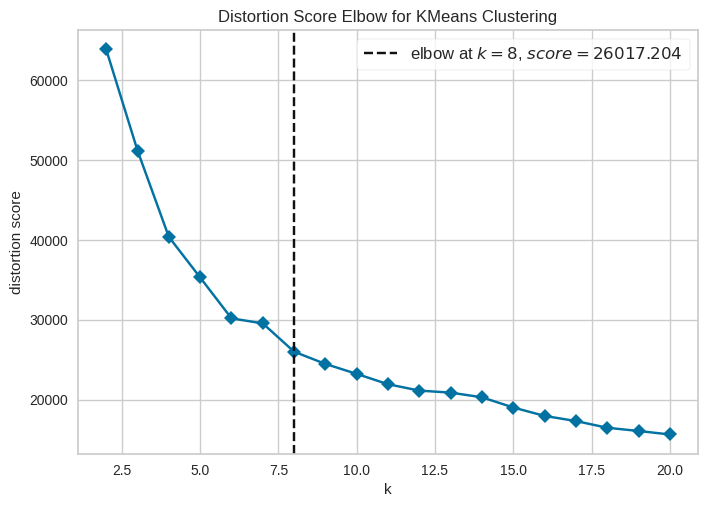

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
km_try = KMeans(random_state=42)
elbow = KElbowVisualizer(km_try, k=(2,21), metric='distortion', timings=False)
elbow.fit(train_features)
elbow.show()

KMeans silhouette:  0.348
KMeans Calinski Harabasz:  1990.801
KMeans Davis bouldin:  1.197


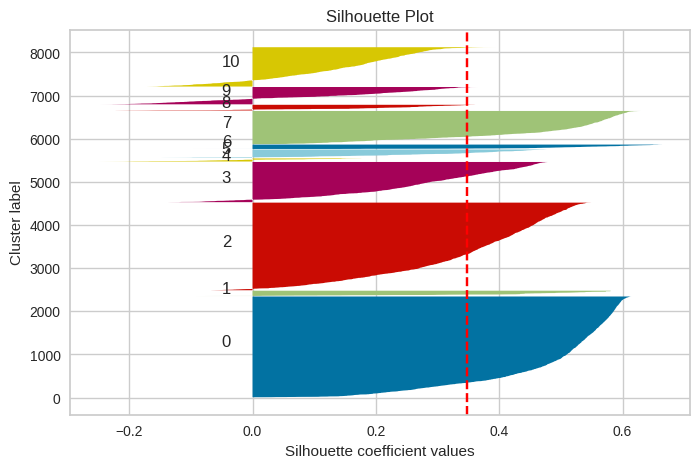

In [ ]:
num_of_clusters = 11
km = KMeans(n_clusters=num_of_clusters, max_iter=150, random_state=42)
kmeans_labels = km.fit_predict(train_features)


km_silhouette = silhouette_score(train_features, kmeans_labels)
km_davis = davies_bouldin_score(train_features, kmeans_labels)
km_clainski = calinski_harabasz_score(train_features, kmeans_labels)
print("KMeans silhouette: ", round(km_silhouette, 3))
print("KMeans Calinski Harabasz: ", round(km_clainski, 3))
print("KMeans Davis bouldin: ", round(km_davis, 3))

plot_silhouette_diagram(train_features, kmeans_labels, num_of_clusters)


# Saving because K-means worked the best for as
save_clusters(train_metadata, kmeans_labels,'kmeans_description', "kmeans")


##### The clustering results from KMeans indicate a moderate level of cluster separation and cohesion. The Silhouette score of 0.336 suggests that while the clusters are somewhat distinct, there is notable overlap between them or internal dispersion, which limits the clarity of the grouping. The Calinski-Harabasz is , indicating that the clusters are well-separated relative to their compactness, which supports the presence of meaningful structure in the data. However, the Davies-Bouldin index, where lower values are better, shows that some clusters may still be too similar or not optimally defined. Together, these metrics imply that the clustering is acceptable but not optimal.

### AgglomerativeClustering

#### Agglomerative clustering is a hierarchical clustering technique that builds nested clusters by iteratively merging the two closest clusters based on a defined linkage criterion, starting with each data point as its own cluster. The process continues until all points are grouped into a single cluster or a stopping condition is met.

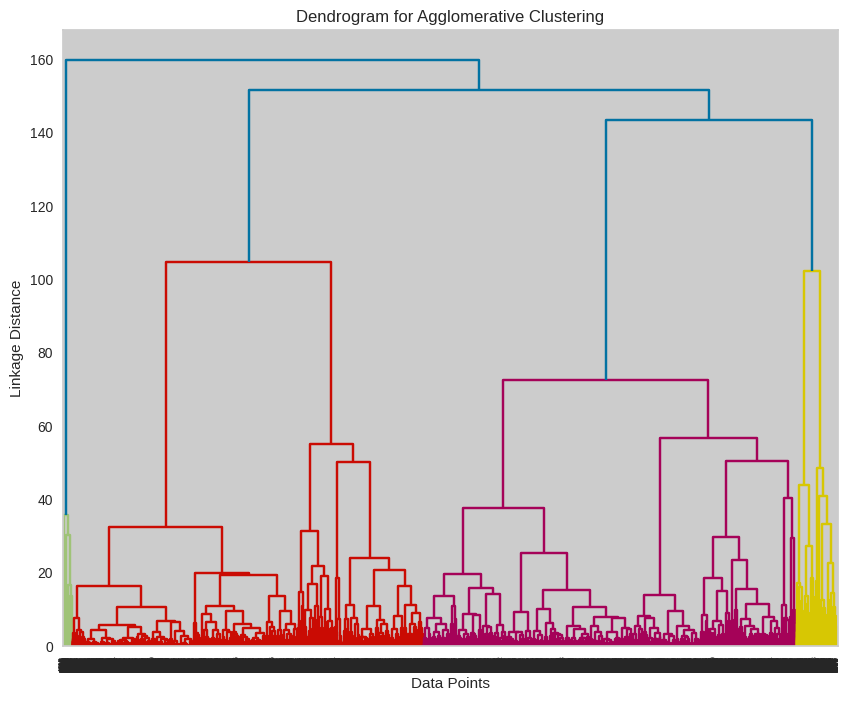

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(train_features, method='ward')

plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Linkage Distance")
plt.show()

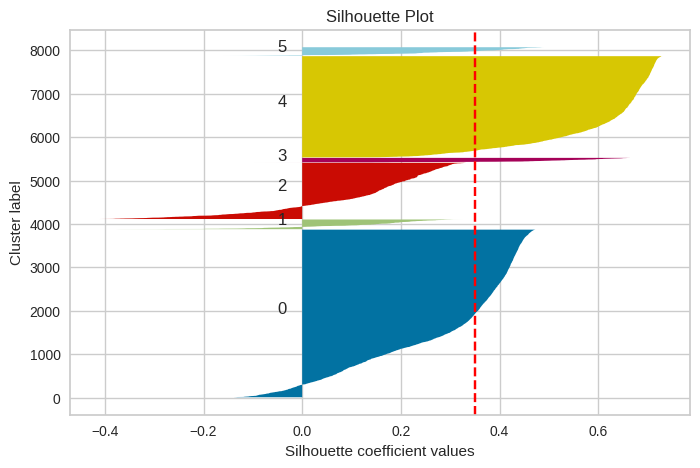

Agglomerative silhouette: 0.35
Agglomerative Calinski Harabasz: 1.117
Agglomerative Davies-Bouldin: 2321.174


In [ ]:
# Fit the model
n_clusters=6
aglo = AgglomerativeClustering(n_clusters=n_clusters)
aglo_labels = aglo.fit_predict(train_features)

# Compute the silhouette scores
silhouette_vals = silhouette_samples(train_features, aglo_labels)
silhouette_avg = silhouette_score(train_features, aglo_labels)

plot_silhouette_diagram(train_features, aglo_labels, n_clusters)
aglo_silhouette = silhouette_score(train_features, aglo_labels)
aglo_clainski = davies_bouldin_score(train_features,aglo_labels)
aglo_davis = calinski_harabasz_score(train_features, aglo_labels)

print("Agglomerative silhouette:", round(aglo_silhouette, 3))
print("Agglomerative Calinski Harabasz:", round(aglo_clainski, 3))
print("Agglomerative Davies-Bouldin:", round(aglo_davis, 3))

##### The agglomerative clustering results indicate suboptimal performance. A silhouette score suggests moderate but weak separation between clusters. The low Calinski-Harabasz index implies minimal between-cluster variance relative to within-cluster dispersion. The high Davies-Bouldin score  further indicates poor cluster compactness and high overlap. Overall, the clustering structure lacks clear definition and likely does not reflect meaningful patterns in the dat

### DBSCAN


#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised clustering algorithm that groups together points that are closely packed and marks points in low-density regions as noise. It does not require the number of clusters to be specified beforehand and can find arbitrarily shaped clusters. Its most important feature is robustness to noise and ability to discover clusters of varying shapes and sizes, making it ideal for spatial and noisy data.

##### In DBSCAN, epsilon (ε) is a distance threshold that defines the radius around a point within which neighboring points are considered part of its neighborhood. It determines how close points must be to each other to be grouped into the same cluster.

##### To find the optimal epsilon (ε) in DBSCAN,  we plot the distances to each point’s k-th nearest neighbor in ascending order. The point where the curve shows a sharp bend (the "elbow") indicates a suitable ε, separating dense clusters from sparser noise regions.

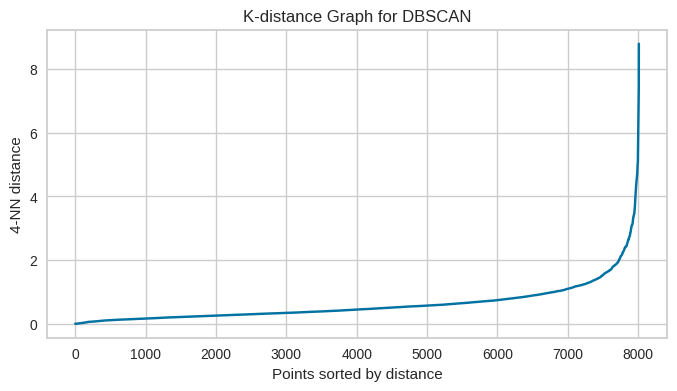

In [42]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors = 4)
nbrs = neigh.fit(train_features)
distances, inidces = nbrs.kneighbors(train_features)
distances = np.sort(distances[:,3])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.ylabel(f"{4}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("K-distance Graph for DBSCAN")
plt.grid(True)
plt.show()

DBSCAN silhouette:  0.209
DBSCAN Calinski Harabasz:  588.429
DBSCAN Davis bouldin:  1.782


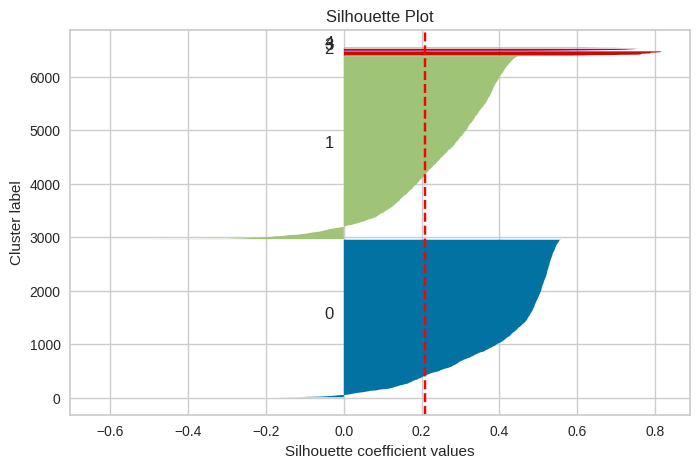

In [43]:
dbscan = DBSCAN(eps=1.05)
dbscan_labels = dbscan.fit_predict(train_features)
dbscan = DBSCAN(eps=1.05, min_samples=21)
dbscan_labels = dbscan.fit_predict(train_features)
dbscan_silhouette = silhouette_score(train_features, dbscan_labels)
dbscan_davis = davies_bouldin_score(train_features, dbscan_labels)
dbscan_calinski = calinski_harabasz_score(train_features, dbscan_labels)
print("DBSCAN silhouette: ", round(dbscan_silhouette, 3))
print("DBSCAN Calinski Harabasz: ", round(dbscan_calinski, 3))
print("DBSCAN Davis bouldin: ", round(dbscan_davis,3))

n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
plot_silhouette_diagram(train_features, dbscan_labels, n_clusters_)


save_clusters(train_features, dbscan_labels,'dbscan_result', "dbscan")

##### The DBSCAN clustering results indicate weaker overall cluster quality compared to KMeans. The Silhouette score suggests that the clusters are loosely defined and may have significant overlap or irregular shapes. The Calinski-Harabasz index is relatively low, implying less separation between clusters and reduced compactness within them. The Davies-Bouldin index is quite high, indicating that the clusters are not well-separated and may be too similar in structure or density. These values collectively suggest that DBSCAN did not perform optimally on this dataset.

#### Based on the DBSCAN results we see, that cluster 1 is the biggest cluster. We will try to split it again using KMEANS. For this purpose we calculate best number of clusters using Elbow metric.


In [ ]:
#Splitting cluster1 with another KMEAN
cluster1 = train_features[dbscan_labels == 1]


elbow = KElbowVisualizer(KMeans(random_state=21), k=(2,21))
elbow.fit(cluster1)
elbow.show()

km_for_cl1 = KMeans(n_clusters=7, random_state=21)
km_cluster1_lables = km_for_cl1.fit_predict(cluster1)
plot_silhouette_diagram(cluster1, km_cluster1_lables, 5)


## Result interpretation and evaluation

As main criterion we chose interpretability of the culsters based on text description, as additional criterion the three used metrics and the silhouette graphs.\

We chose the 7-Means with the following interpretation:


### Cluster 0: "Processed & Packaged Foods"

    Example items: Eggo mini muffin tops, vegetable chicken soup (low sodium), baby food, strudel.

    Interpretation: This cluster contains highly processed, packaged, or convenience foods, including baby products and ready-to-eat items.

### Cluster 1: "Seafood & Exotic Fish"

    Example items: Mackerel, whale shark, parava, parcus.

    Interpretation: Composed primarily of fish and possibly marine creatures, some of which may be regionally specific or exotic.

### Cluster 4: "Vegetables & Soups"

    Example items: Cream of asparagus soup, gogu leaves, chrysanthemum garland, carrots.

    Interpretation: A mix of vegetables (fresh and prepared) and vegetable-based soups, including baby food variants.

### Cluster 5: "Meat Cuts & Cooked Meats"

    Example items: Pork ham, lamb shank, beef chuck steak, spareribs.

    Interpretation: This group is centered around raw and cooked meats, including detailed meat cuts from various animals.

### Cluster 6: "Grains, Pulses & Seeds"

    Example items: Jowar, black pepper, pinto beans, mung beans, sunflower seeds.

    Interpretation: Focused on plant-based dry goods such as grains, legumes, and seeds — typically uncooked or minimally processed.
